In [1]:
import numpy as np
import numpy.random as ndm
import torch
from torch import nn
import pandas as pd
#import matplotlib.pyplot as plt
from data_generator import generate_case_3
from g_deep import g_D
from CCP_estimation import CCP_est
from I_spline import I_S
from Least_FD import LFD
from g_dcp import g_DCP3
from Theta_estimate import Theta_est
from zeta_estimate import zeta_est
from iteration_dcp import Est_dcp2

In [2]:
def set_seed(seed):
    np.random.seed(seed) 
    torch.manual_seed(seed) 

set_seed(12)
tau = 10
p = 3 
n = 2000
corr = 0.5 
n_layer = 3
n_node = 64
n_epoch = 200 #
Set_lr = np.array([2.8e-4, 3.2e-4, 4.2e-4]) #learning rate
n_lr = 5e-4
Theta = [-1, 2]
zeta = 2

#dim_x = X_test.shape[0]
u_value = np.array(np.linspace(0, tau, 50), dtype="float32") 
Lambda_true = np.sqrt(u_value) 
m = 10 
nodevec = np.array(np.linspace(0, tau, m+2), dtype="float32")

m0 = 4 
nodevec0 = np.array(np.linspace(0, 2, m0+2), dtype="float32")

node_D = np.array([35, 30, 30])   #deep
lr_D = np.array([4e-4, 4e-4, 4e-4])


In [3]:
train_data = generate_case_3(n, corr, Theta, zeta)
test_data = generate_case_3(200, corr, Theta, zeta)
X_test = test_data['X']
Z_2_test = test_data['Z_2']
g_true = test_data['g_X']
h_true = test_data['h_X']
Res_true = test_data['g_X_C']

In [4]:

c0 = np.array(0.1*np.ones(m+p), dtype="float32") 
Theta0 = np.array([-1,1], dtype='float32')
Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,n_lr,n_epoch,nodevec,m,c0)

{'g_train': array([0.3594506 , 4.987304  , 0.78303385, ..., 0.8028209 , 0.19401646,
        0.35945058], dtype=float32),
 'g_test': array([4.122568  , 0.3486045 , 3.89396   , 3.80393   , 0.67761075,
        0.15469995, 2.557252  , 4.987304  , 4.987304  , 0.26117665,
        4.1714892 , 0.8811031 , 4.8634944 , 2.6993554 , 0.56579065,
        2.7355866 , 4.775933  , 0.6673013 , 0.5372665 , 1.6413552 ,
        0.4052837 , 0.36347204, 2.854804  , 4.811565  , 2.712811  ,
        0.3594506 , 0.32323137, 0.35274482, 0.3594506 , 0.30514878,
        0.87910885, 0.2968818 , 2.668158  , 0.3594506 , 0.41501114,
        1.5843219 , 0.36212388, 0.34142417, 0.27059704, 3.623339  ,
        3.7239704 , 1.7679847 , 0.3508148 , 1.8136401 , 0.2946843 ,
        1.7870225 , 0.50326663, 0.47773755, 0.18260482, 2.069254  ,
        0.21705878, 3.8009887 , 0.35483408, 4.1878943 , 0.3281641 ,
        3.7902193 , 1.0156509 , 2.7235456 , 0.36632735, 0.754972  ,
        0.3594506 , 0.24120271, 4.587335  , 0.2527489

The experiment with zeta start from np.mean(Z_2_train)

In [ ]:
G_test_deep = []
H_test_deep = []
Res_test_deep = []
ThetaM = []
zetaM = []
Re_G_deep = []
Re_H_deep = []
Re_Res_deep = []
for b in range(50):
    print('n=', n, 'b=', b )
    set_seed(12 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([-0.4,0.9], dtype='float32')
    train_data = generate_case_3(n, corr, Theta, zeta)
    result = Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,n_lr,n_epoch,nodevec,m,c0)
    Theta_res = result['Theta'] # vector to add row by row
    ThetaM.append(Theta_res)
    zeta_res = result['zeta']
    zetaM.append(zeta_res)
    #C_res = result['C_index']
    g_test_res = result['g_test']
    G_test_deep.append(g_test_res) # vector to add row by row
    h_test_res = result['h_test']
    H_test_deep.append(h_test_res) # vector to add row by row
    Res_test_res = result['Res_test']
    Res_test_deep.append(Res_test_res) # vector to add row by row
    Re_G_deep.append(np.sqrt(np.mean((g_test_res-np.mean(g_test_res)-g_true)**2)/np.mean(g_true**2))) #loss of g(x)
    Re_H_deep.append(np.sqrt(np.mean((h_test_res-np.mean(h_test_res)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_deep.append(np.sqrt(np.mean((Res_test_res-np.mean(Res_test_res)-Res_true)**2)/np.mean(Res_true**2)))

Error_g_dcp = np.mean(np.array(G_test_deep), axis=0) - g_true
Error_h_dcp = np.mean(np.array(H_test_deep), axis=0) - h_true
Error_Res_dcp = np.mean(np.array(Res_test_deep), axis=0) - Res_true
Theta_dcp = np.mean(np.array(ThetaM),axis=0)
zeta_dcp = np.mean(np.array(zeta_res))
Sd_G_deep = (np.sqrt(np.mean((Re_G_deep-np.mean(Re_G_deep))**2)))
Sd_H_deep = (np.sqrt(np.mean((Re_H_deep-np.mean(Re_H_deep))**2)))
Sd_Res_deep = (np.sqrt(np.mean((Re_Res_deep-np.mean(Re_Res_deep))**2)))
#print(Error_g_dcp)
#print(Error_h_dcp)
#print(Error_Res_dcp)
print(Theta_dcp)
print(zeta_dcp)
print(np.mean(Re_G_deep))
print(np.mean(Re_H_deep))
print(np.mean(Re_Res_deep))
print(Sd_G_deep)
print(Sd_H_deep)
print(Sd_Res_deep)
#print(np.mean(Error_g_dcp))
#print(np.mean(Error_Res_dcp))
#print(np.mean(np.mean(np.array(G_test_deep), axis=0)))
#print(np.mean(g_true))

The experiment with zeta==2, to adjust the learning rates and other tunning parameters

In [ ]:
from iteration_dcp import Est_dcp2exp
G_test_deep = []
H_test_deep = []
Res_test_deep = []
ThetaM = []
zetaM = []
Re_G_deep = []
Re_H_deep = []
Re_Res_deep = []
for b in range(50):
    print('n=', n, 'b=', b)
    set_seed(12 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([0,0], dtype='float32')
    train_data = generate_case_3(n, corr, Theta, zeta)
    result = Est_dcp2exp(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,n_lr,n_epoch,nodevec,m,c0)
    Theta_res = result['Theta'] # vector to add row by row
    ThetaM.append(Theta_res)
    zeta_res = result['zeta']
    zetaM.append(zeta_res)
    #C_res = result['C_index']
    g_test_res = result['g_test']
    G_test_deep.append(g_test_res) # vector to add row by row
    h_test_res = result['h_test']
    H_test_deep.append(h_test_res) # vector to add row by row
    Res_test_res = result['Res_test']
    Res_test_deep.append(Res_test_res) # vector to add row by row
    Re_G_deep.append(np.sqrt(np.mean((g_test_res-np.mean(g_test_res)-g_true)**2)/np.mean(g_true**2))) #loss of g(x)
    Re_H_deep.append(np.sqrt(np.mean((h_test_res-np.mean(h_test_res)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_deep.append(np.sqrt(np.mean((Res_test_res-np.mean(Res_test_res)-Res_true)**2)/np.mean(Res_true**2)))
Error_g_dcp = np.mean(np.array(G_test_deep), axis=0) - g_true
Error_h_dcp = np.mean(np.array(H_test_deep), axis=0) - h_true
Error_Res_dcp = np.mean(np.array(Res_test_deep), axis=0) - Res_true
Theta_dcp = np.mean(np.array(ThetaM),axis=0)
zeta_dcp = np.mean(np.array(zeta_res))
Sd_G_deep = (np.sqrt(np.mean((Re_G_deep-np.mean(Re_G_deep))**2)))
Sd_H_deep = (np.sqrt(np.mean((Re_H_deep-np.mean(Re_H_deep))**2)))
Sd_Res_deep = (np.sqrt(np.mean((Re_Res_deep-np.mean(Re_Res_deep))**2)))
#print(Error_g_dcp)
#print(Error_h_dcp)
#print(Error_Res_dcp)
print(Theta_dcp)
print(zeta_dcp)
print(np.mean(Re_G_deep))
print(np.mean(Re_H_deep))
print(np.mean(Re_Res_deep))
print(Sd_G_deep)
print(Sd_H_deep)
print(Sd_Res_deep)


In [ ]:
n = 10000
Z_2 = np.random.normal(loc=2, scale=1, size=n)
Z_2 = np.clip(Z_2, 1.5, 2.5)
mean = np.zeros(5)
cov = np.identity(5)*(1-corr) + np.ones((5, 5))*corr
def multivariatet(mu,Sigma,N,M):
    d = len(Sigma)
    g = np.tile(np.random.gamma(N/2,1/2,M),(d,1)).T
    Z = np.random.multivariate_normal(np.zeros(d),Sigma,M)
    return mu + Z/np.sqrt(g/N)

X = multivariatet(mean,cov,5,n)
X = np.clip(X, 0, 2) #t-distributed with [0,2]
g_X = np.sqrt(X[:,0]*X[:,1])/5 + X[:,2]**2*X[:,3]/4 \
    + np.log(X[:,3]+1)/3 + np.exp(X[:,4])/2 
h_X = 0.2*(np.sqrt(X[:,0]*X[:,1])/5 + X[:,2]**2*X[:,3]/4 \
    + np.log(X[:,3]+1)/3 + np.exp(X[:,4])/2)**2 
Ind = (Z_2>zeta)
g_X_C = g_X+h_X*Ind
print(np.mean(g_X))
print(np.mean(h_X))
print(np.mean(g_X_C))

In [37]:
from Least_FDcp import LFDCP
from iteration_dcp import Est_dcp2exp
set_seed(1924)

train_data = generate_case_3(2000, corr, Theta, zeta)
U_train = train_data['U']
De_train = train_data['De']
Z_train = train_data['Z']
Z_2_train = train_data['Z_2']
    
test_data = generate_case_3(200, corr, Theta, zeta)
X_test = test_data['X']
Z_2_test = test_data['Z_2']
g_true = test_data['g_X']
h_true = test_data['h_X']
Res_true = test_data['g_X_C']
c0 = np.array(0.1*np.ones(m+p), dtype="float32") 
Theta0 = np.array([0,0], dtype='float32')
# Estimation
result = Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,5.5e-4,n_epoch,nodevec,m,c0)
zeta_res = result['zeta'] # change point
Theta_res = result['Theta']
# Score and Information
Z1 = Z_train
Z2 = Z_train*(Z_2_train>zeta_res)
a_b1 = LFDCP(Z1,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=2e-3,n_epoch=n_epoch)
a_b2 = LFDCP(Z2,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=2e-3,n_epoch=n_epoch)
Z_train1 = np.vstack((Z_train, Z_train*(Z_2_train>zeta)))
Z_train1 = Z_train1.T
h_v_deep = I_S(m,result['c'],U_train,nodevec) * np.exp(Z_train1@result['Theta'] + result['Res_train'])
Q_y_deep = h_v_deep * (De_train * np.exp(-h_v_deep)/(1-np.exp(-h_v_deep)) - (1-De_train))
Info = np.zeros((2,2))
Info[0,0] = np.mean(Q_y_deep**2 * (Z1-a_b1)**2)
Info[1,1] = np.mean(Q_y_deep**2 * (Z2-a_b2)**2)
Info[0,1] = np.mean(Q_y_deep**2 * (Z1-a_b1)*(Z2-a_b2))
Info[1,0] = Info[0,1]
Sigma = np.linalg.inv(Info)/n
sd1 = np.sqrt(Sigma[0,0])
sd2 = np.sqrt(Sigma[1,1])

#print(h_v_deep.shape)
print(Info)
print(Sigma)
print(sd1)
print(sd2)  
print(zeta_res)
print(Theta_res)
print(np.array([Theta_res[0]-1.96*sd1,Theta_res[0]+1.96*sd1]))
print(np.array([Theta_res[1]-1.96*sd2,Theta_res[1]+1.96*sd2]))


[[0.03607644 0.01642676]
 [0.01642676 0.02916752]]
[[ 0.01863925 -0.01049738]
 [-0.01049738  0.02305434]]
0.1365256556505325
0.1518365620040072
2.02
[-1.0124771   2.13598832]
[-1.28006738 -0.74488681]
[1.83838866 2.43358798]


In [13]:
print(np.linalg.inv(Info)/n)

[[ 0.00853562 -0.00665665]
 [-0.00665665  0.01661727]]


In [38]:
from Least_FDcp import LFDCP
G_test_deep = []; H_test_deep = []; Res_test_deep = []
ThetaM = []; zetaM = []; C_deep = []
Info1_deep = []; Info2_deep = []; Re_G_deep = []; Re_H_deep = []; Re_Res_deep = []
for b in range(100):
    print('n=', n, 'b=', b )
    set_seed(2024 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([0,0], dtype='float32')
    train_data = generate_case_3(n, corr, Theta, zeta)  #g and h are deep function
    U_train = train_data['U']
    De_train = train_data['De']
    Z_train = train_data['Z']
    Z_2_train = train_data['Z_2']
    
    # Estimation
    result = Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,n_lr,n_epoch,nodevec,m,c0)

    # record the results
    Theta_res = result['Theta'] # vector to add row by row
    ThetaM.append(Theta_res)
    zeta_res = result['zeta'] # change point
    zetaM.append(zeta_res)
    C_res = result['C_index'] # baseline cumulative hazard
    C_deep.append(C_res)
    
    # test data to calculate Re and Sd_Re for g and h
    g_test_res = result['g_test'] 
    G_test_deep.append(g_test_res) # vector to add row by row
    h_test_res = result['h_test']
    H_test_deep.append(h_test_res) # vector to add row by row
    Res_test_res = result['Res_test']
    Res_test_deep.append(Res_test_res) # vector to add row by row
    Re_G_deep.append(np.sqrt(np.mean((g_test_res-np.mean(g_test_res)-g_true)**2)/np.mean(g_true**2))) #Re loss of g(x)
    Re_H_deep.append(np.sqrt(np.mean((h_test_res-np.mean(h_test_res)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_deep.append(np.sqrt(np.mean((Res_test_res-np.mean(Res_test_res)-Res_true)**2)/np.mean(Res_true**2)))

    # Calculataion of the score and information
    Z1 = Z_train
    Z2 = Z_train*(Z_2_train>zeta_res)
    a_b1 = LFDCP(Z1,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=64,n_lr=2e-3,n_epoch=n_epoch)
    a_b2 = LFDCP(Z2,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=4,n_node=64,n_lr=1e-2,n_epoch=n_epoch)
    Z_train1 = np.vstack((Z_train, Z_train*(Z_2_train>zeta)))
    Z_train1 = Z_train1.T  
    h_v_deep = I_S(m,result['c'],U_train,nodevec) * np.exp(Z_train1@result['Theta'] + result['Res_train'])
    Q_y_deep = h_v_deep * (De_train * np.exp(-h_v_deep)/(1-np.exp(-h_v_deep)+1e-8) - (1-De_train))
    Info = np.zeros((2,2))
    Info[0,0] = np.mean(Q_y_deep**2 * (Z1-a_b1)**2)
    Info[1,1] = np.mean(Q_y_deep**2 * (Z2-a_b2)**2)
    Info[0,1] = np.mean(Q_y_deep**2 * (Z1-a_b1)*(Z2-a_b2))
    Info[1,0] = Info[0,1]
    Sigma = np.linalg.inv(Info)/n
    se1 = np.sqrt(Sigma[0,0])
    Info1_deep.append(se1)
    se2 = np.sqrt(Sigma[1,1])
    Info2_deep.append(se2)


n= 2000 b= 0
n= 2000 b= 1
n= 2000 b= 2
n= 2000 b= 3
n= 2000 b= 4
n= 2000 b= 5
n= 2000 b= 6
n= 2000 b= 7
n= 2000 b= 8
n= 2000 b= 9
n= 2000 b= 10
n= 2000 b= 11
n= 2000 b= 12
n= 2000 b= 13
n= 2000 b= 14
n= 2000 b= 15
n= 2000 b= 16
n= 2000 b= 17
n= 2000 b= 18
n= 2000 b= 19
n= 2000 b= 20
n= 2000 b= 21
n= 2000 b= 22
n= 2000 b= 23
n= 2000 b= 24
n= 2000 b= 25
n= 2000 b= 26
n= 2000 b= 27
n= 2000 b= 28
n= 2000 b= 29
n= 2000 b= 30
n= 2000 b= 31
n= 2000 b= 32
n= 2000 b= 33
n= 2000 b= 34
n= 2000 b= 35
n= 2000 b= 36
n= 2000 b= 37
n= 2000 b= 38
n= 2000 b= 39
n= 2000 b= 40
n= 2000 b= 41
n= 2000 b= 42
n= 2000 b= 43
n= 2000 b= 44
n= 2000 b= 45
n= 2000 b= 46
n= 2000 b= 47
n= 2000 b= 48
n= 2000 b= 49
n= 2000 b= 50
n= 2000 b= 51
n= 2000 b= 52
n= 2000 b= 53
n= 2000 b= 54
n= 2000 b= 55
n= 2000 b= 56
n= 2000 b= 57
n= 2000 b= 58
n= 2000 b= 59
n= 2000 b= 60
n= 2000 b= 61
n= 2000 b= 62
n= 2000 b= 63
n= 2000 b= 64
n= 2000 b= 65
n= 2000 b= 66
n= 2000 b= 67
n= 2000 b= 68
n= 2000 b= 69
n= 2000 b= 70
n= 2000 b= 71
n=

In [39]:
#Error_g_dcp = np.mean(np.array(G_test_deep), axis=0) - g_true
#Error_h_dcp = np.mean(np.array(H_test_deep), axis=0) - h_true
#Error_Res_dcp = np.mean(np.array(Res_test_deep), axis=0) - Res_true
Theta_dcp = np.mean(np.array(ThetaM),axis=0)
zeta_dcp = np.mean(np.array(zeta_res))
Sd_G_deep = (np.sqrt(np.mean((Re_G_deep-np.mean(Re_G_deep))**2)))
Sd_H_deep = (np.sqrt(np.mean((Re_H_deep-np.mean(Re_H_deep))**2)))
Sd_Res_deep = (np.sqrt(np.mean((Re_Res_deep-np.mean(Re_Res_deep))**2)))
ThetaM1 = np.array(ThetaM)[:,0]
ThetaM2 = np.array(ThetaM)[:,1]
Bias1_deep = (np.mean(np.array(ThetaM1))-Theta[0])
Sse1_deep = (np.sqrt(np.mean((np.array(ThetaM1)-np.mean(np.array(ThetaM1)))**2)))
Ese1_deep = (np.mean(np.array(Info1_deep)))
Cp1_deep = (np.mean((np.array(ThetaM1)-1.96*np.array(Info1_deep)<=Theta[0])*\
                       (Theta[0]<=np.array(ThetaM1)+1.96*np.array(Info1_deep))))
Bias2_deep = (np.mean(np.array(ThetaM2))-Theta[1])
Sse2_deep = (np.sqrt(np.mean((np.array(ThetaM2)-np.mean(np.array(ThetaM2)))**2)))
Ese2_deep = (np.mean(np.array(Info2_deep)))
Cp2_deep = (np.mean((np.array(ThetaM2)-1.96*np.array(Info2_deep)<=Theta[1])*\
                       (Theta[1]<=np.array(ThetaM2)+1.96*np.array(Info2_deep))))
#print(Error_g_dcp)
#print(Error_h_dcp)
#print(Error_Res_dcp)
print('Estimation for reg para and change point para:')
print('Theta: ', Theta_dcp)
print('zeta: ', zeta_dcp)
print('Estimation for Re and Sd of deep function:')
print('Re_g: ', np.mean(Re_G_deep))
print('Re_h: ', np.mean(Re_H_deep))
print('Re_total: ', np.mean(Re_Res_deep))
print('SdRe_g: ', Sd_G_deep)
print('SdRe_h: ', Sd_H_deep)
print('SdRe_total: ', Sd_Res_deep)
print('Inference for beta:')
print('Bias1:', Bias1_deep)
print('Sse1: ', Sse1_deep)
print('Ese1: ', Ese1_deep)
print('Cp1: ', Cp1_deep)
print('Inference for gamma:')
print('Bias2:', Bias2_deep)
print('Sse2: ', Sse2_deep)
print('Ese2: ', Ese2_deep)
print('Cp2: ', Cp2_deep)
#print(np.mean(Error_g_dcp))
#print(np.mean(Error_Res_dcp))
#print(np.mean(np.mean(np.array(G_test_deep), axis=0)))
#print(np.mean(g_true))

Estimation for reg para and change point para:
Theta:  [-1.01340695  1.96601995]
zeta:  2.01
Estimation for Re and Sd of deep function:
Re_g:  0.19487503
Re_h:  0.73654497
Re_total:  0.4387796
SdRe_g:  0.029547276
SdRe_h:  0.07078298
SdRe_total:  0.043463487
Inference for beta:
Bias1: -0.01340694537067777
Sse1:  0.13634699756953278
Ese1:  0.14358848674168287
Cp1:  0.96
Inference for gamma:
Bias2: -0.03398005396662773
Sse2:  0.1833612210234886
Ese2:  0.17812826560012582
Cp2:  0.95


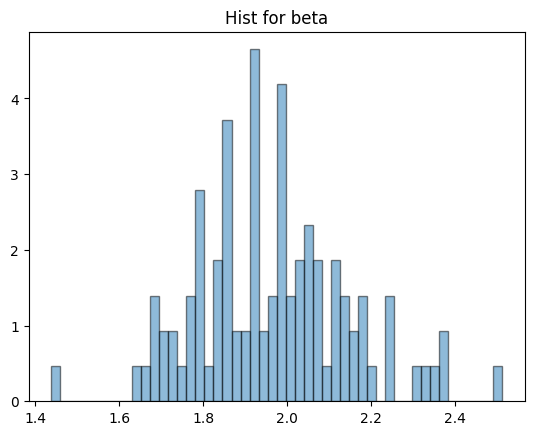

In [40]:
import matplotlib.pyplot as plt
plt.hist(ThetaM2, bins = 50, density=True, alpha=0.5, edgecolor='black')
plt.title('Hist for beta')
plt.show()

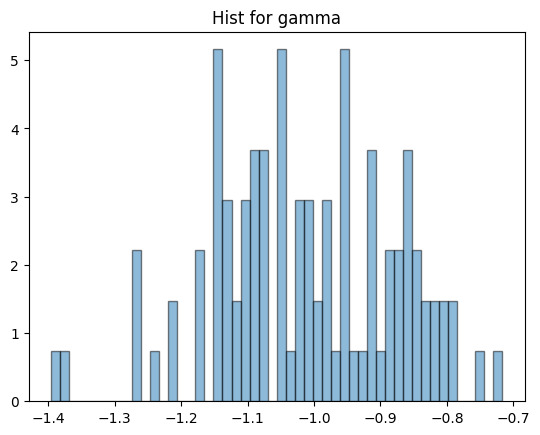

In [41]:
plt.hist(ThetaM1, bins = 50, density=True, alpha=0.5, edgecolor='black')
plt.title('Hist for gamma')
plt.show()

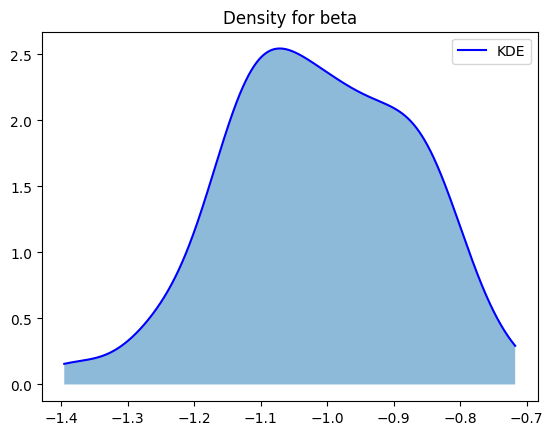

In [42]:
from scipy.stats import gaussian_kde
kde1 = gaussian_kde(ThetaM1)
xval = np.linspace(min(ThetaM1),max(ThetaM1),1000)
yval = kde1(xval)
plt.plot(xval,yval,label='KDE',color='blue')
plt.fill_between(xval,yval,alpha=0.5)
plt.title('Density for beta')
plt.legend()
plt.show()

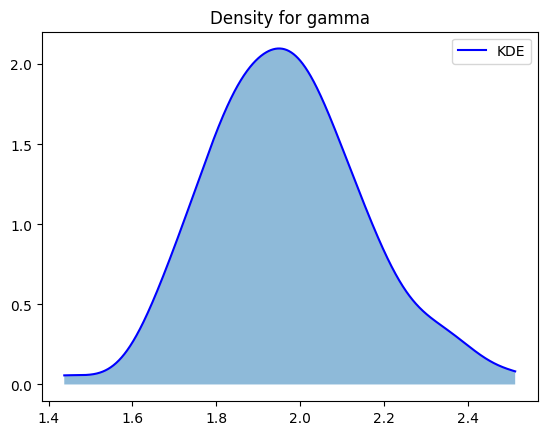

In [43]:
kde2 = gaussian_kde(ThetaM2)
xval2 = np.linspace(min(ThetaM2),max(ThetaM2),1000)
yval2 = kde2(xval2)
plt.plot(xval2,yval2,label='KDE',color='blue')
plt.fill_between(xval2,yval2,alpha=0.5)
plt.title('Density for gamma')
plt.legend()
plt.show()

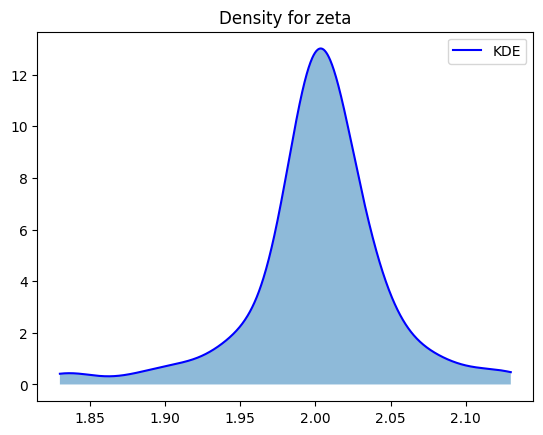

In [44]:
kde3 = gaussian_kde(zetaM)
xval3 = np.linspace(min(zetaM),max(zetaM),1000)
yval3 = kde3(xval3)
plt.plot(xval3,yval3,label='KDE',color='blue')
plt.fill_between(xval3,yval3,alpha=0.5)
plt.title('Density for zeta')
plt.legend()
plt.show()

n= 2000 b= 0
n= 2000 b= 1
n= 2000 b= 2
n= 2000 b= 3
n= 2000 b= 4
n= 2000 b= 5
n= 2000 b= 6
n= 2000 b= 7
n= 2000 b= 8
n= 2000 b= 9
n= 2000 b= 10
n= 2000 b= 11
n= 2000 b= 12
n= 2000 b= 13
n= 2000 b= 14
n= 2000 b= 15
n= 2000 b= 16
n= 2000 b= 17
n= 2000 b= 18
n= 2000 b= 19
n= 2000 b= 20
n= 2000 b= 21
n= 2000 b= 22
n= 2000 b= 23
n= 2000 b= 24
n= 2000 b= 25
n= 2000 b= 26
n= 2000 b= 27
n= 2000 b= 28
n= 2000 b= 29
n= 2000 b= 30
n= 2000 b= 31
n= 2000 b= 32
n= 2000 b= 33
n= 2000 b= 34
n= 2000 b= 35
n= 2000 b= 36
n= 2000 b= 37
n= 2000 b= 38
n= 2000 b= 39
n= 2000 b= 40
n= 2000 b= 41
n= 2000 b= 42
n= 2000 b= 43
n= 2000 b= 44
n= 2000 b= 45
n= 2000 b= 46
n= 2000 b= 47
n= 2000 b= 48
n= 2000 b= 49
n= 2000 b= 50
n= 2000 b= 51
n= 2000 b= 52
n= 2000 b= 53
n= 2000 b= 54
n= 2000 b= 55
n= 2000 b= 56
n= 2000 b= 57
n= 2000 b= 58
n= 2000 b= 59
n= 2000 b= 60
n= 2000 b= 61
n= 2000 b= 62
n= 2000 b= 63
n= 2000 b= 64
n= 2000 b= 65
n= 2000 b= 66
n= 2000 b= 67
n= 2000 b= 68
n= 2000 b= 69
n= 2000 b= 70
n= 2000 b= 71
n=

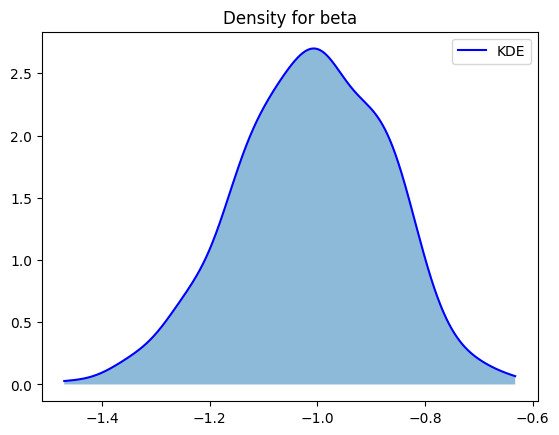

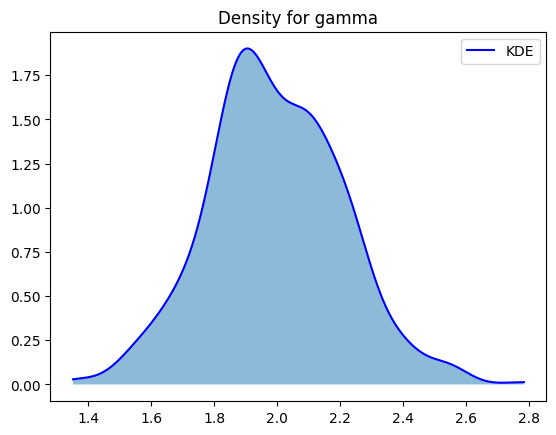

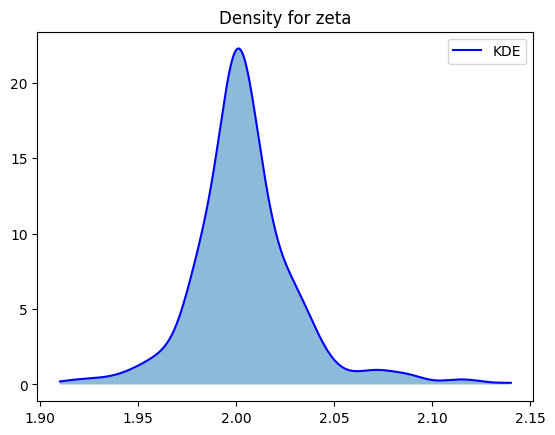

In [99]:
from Least_FDcp import LFDCP
G_test_deep = []; H_test_deep = []; Res_test_deep = []
ThetaM = []; zetaM = []; C_deep = []
Info1_deep = []; Info2_deep = []; Re_G_deep = []; Re_H_deep = []; Re_Res_deep = []
for b in range(500):
    print('n=', n, 'b=', b )
    set_seed(15 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([0,1], dtype='float32')
    train_data = generate_case_3(2000, corr, Theta, zeta)  #g and h are deep function
    U_train = train_data['U']
    De_train = train_data['De']
    Z_train = train_data['Z']
    Z_2_train = train_data['Z_2']
    
    # Estimation
    result = Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,n_layer,n_node,3.8e-4,n_epoch,nodevec,m,c0)

    # record the results
    Theta_res = result['Theta'] # vector to add row by row
    ThetaM.append(Theta_res)
    zeta_res = result['zeta'] # change point
    zetaM.append(zeta_res)
    C_res = result['C_index'] # baseline cumulative hazard
    C_deep.append(C_res)
    
    # test data to calculate Re and Sd_Re for g and h
    g_test_res = result['g_test'] 
    G_test_deep.append(g_test_res) # vector to add row by row
    h_test_res = result['h_test']
    H_test_deep.append(h_test_res) # vector to add row by row
    Res_test_res = result['Res_test']
    Res_test_deep.append(Res_test_res) # vector to add row by row
    Re_G_deep.append(np.sqrt(np.mean((g_test_res-np.mean(g_test_res)-g_true)**2)/np.mean(g_true**2))) #Re loss of g(x)
    Re_H_deep.append(np.sqrt(np.mean((h_test_res-np.mean(h_test_res)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_deep.append(np.sqrt(np.mean((Res_test_res-np.mean(Res_test_res)-Res_true)**2)/np.mean(Res_true**2)))

    # Calculataion of the score and information
    Z1 = Z_train
    Z2 = Z_train*(Z_2_train>zeta_res)
    a_b1 = LFDCP(Z1,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=2e-3,n_epoch=n_epoch)
    a_b2 = LFDCP(Z2,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=1e-2,n_epoch=300)
    Z_train1 = np.vstack((Z_train, Z_train*(Z_2_train>zeta)))
    Z_train1 = Z_train1.T  
    h_v_deep = I_S(m,result['c'],U_train,nodevec) * np.exp(Z_train1@result['Theta'] + result['Res_train'])
    Q_y_deep = h_v_deep * (De_train * np.exp(-h_v_deep)/(1-np.exp(-h_v_deep)+1e-8) - (1-De_train))
    Info = np.zeros((2,2))
    Info[0,0] = np.mean(Q_y_deep**2 * (Z1-a_b1)**2)
    Info[1,1] = np.mean(Q_y_deep**2 * (Z2-a_b2)**2)
    Info[0,1] = np.mean(Q_y_deep**2 * (Z1-a_b1)*(Z2-a_b2))
    Info[1,0] = Info[0,1]
    Sigma = np.linalg.inv(Info)/n
    se1 = np.sqrt(Sigma[0,0])
    Info1_deep.append(se1)
    se2 = np.sqrt(Sigma[1,1])
    Info2_deep.append(se2)


#Error_g_dcp = np.mean(np.array(G_test_deep), axis=0) - g_true
#Error_h_dcp = np.mean(np.array(H_test_deep), axis=0) - h_true
#Error_Res_dcp = np.mean(np.array(Res_test_deep), axis=0) - Res_true
Theta_dcp = np.mean(np.array(ThetaM),axis=0)
zeta_dcp = np.mean(np.array(zeta_res))
Sd_G_deep = (np.sqrt(np.mean((Re_G_deep-np.mean(Re_G_deep))**2)))
Sd_H_deep = (np.sqrt(np.mean((Re_H_deep-np.mean(Re_H_deep))**2)))
Sd_Res_deep = (np.sqrt(np.mean((Re_Res_deep-np.mean(Re_Res_deep))**2)))
ThetaM1 = np.array(ThetaM)[:,0]
ThetaM2 = np.array(ThetaM)[:,1]
Bias1_deep = (np.mean(np.array(ThetaM1))-Theta[0])
Sse1_deep = (np.sqrt(np.mean((np.array(ThetaM1)-np.mean(np.array(ThetaM1)))**2)))
Ese1_deep = (np.mean(np.array(Info1_deep)))
Cp1_deep = (np.mean((np.array(ThetaM1)-1.96*np.array(Info1_deep)<=Theta[0])*\
                       (Theta[0]<=np.array(ThetaM1)+1.96*np.array(Info1_deep))))
Bias2_deep = (np.mean(np.array(ThetaM2))-Theta[1])
Sse2_deep = (np.sqrt(np.mean((np.array(ThetaM2)-np.mean(np.array(ThetaM2)))**2)))
Ese2_deep = (np.mean(np.array(Info2_deep)))
Cp2_deep = (np.mean((np.array(ThetaM2)-1.96*np.array(Info2_deep)<=Theta[1])*\
                       (Theta[1]<=np.array(ThetaM2)+1.96*np.array(Info2_deep))))
#print(Error_g_dcp)
#print(Error_h_dcp)
#print(Error_Res_dcp)
print('Estimation for reg para and change point para:')
print('Theta: ', Theta_dcp)
print('zeta: ', zeta_dcp)
print('Estimation for Re and Sd of deep function:')
print('Re_g: ', np.mean(Re_G_deep))
print('Re_h: ', np.mean(Re_H_deep))
print('Re_total: ', np.mean(Re_Res_deep))
print('SdRe_g: ', Sd_G_deep)
print('SdRe_h: ', Sd_H_deep)
print('SdRe_total: ', Sd_Res_deep)
print('Inference for beta:')
print('Bias1:', Bias1_deep)
print('Sse1: ', Sse1_deep)
print('Ese1: ', Ese1_deep)
print('Cp1: ', Cp1_deep)
print('Inference for gamma:')
print('Bias2:', Bias2_deep)
print('Sse2: ', Sse2_deep)
print('Ese2: ', Ese2_deep)
print('Cp2: ', Cp2_deep)
#print(np.mean(Error_g_dcp))
#print(np.mean(Error_Res_dcp))
#print(np.mean(np.mean(np.array(G_test_deep), axis=0)))
#print(np.mean(g_true))

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
kde1 = gaussian_kde(ThetaM1)
xval = np.linspace(min(ThetaM1),max(ThetaM1),1000)
yval = kde1(xval)
plt.plot(xval,yval,label='KDE',color='blue')
plt.fill_between(xval,yval,alpha=0.5)
plt.title('Density for beta')
plt.legend()
plt.show()

kde2 = gaussian_kde(ThetaM2)
xval2 = np.linspace(min(ThetaM2),max(ThetaM2),1000)
yval2 = kde2(xval2)
plt.plot(xval2,yval2,label='KDE',color='blue')
plt.fill_between(xval2,yval2,alpha=0.5)
plt.title('Density for gamma')
plt.legend()
plt.show()

kde3 = gaussian_kde(zetaM)
xval3 = np.linspace(min(zetaM),max(zetaM),1000)
yval3 = kde3(xval3)
plt.plot(xval3,yval3,label='KDE',color='blue')
plt.fill_between(xval3,yval3,alpha=0.5)
plt.title('Density for zeta')
plt.legend()
plt.show()


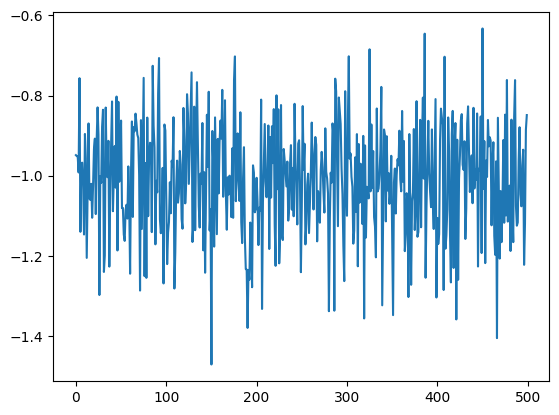

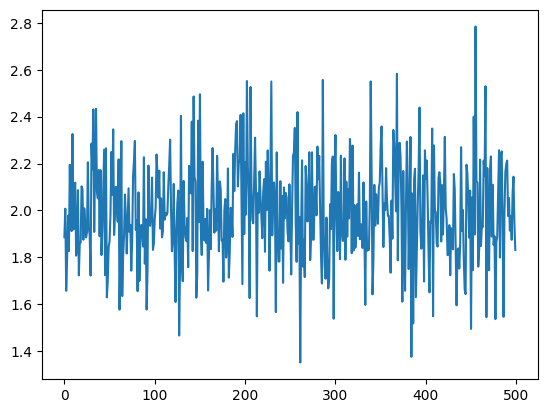

In [100]:
plt.plot(ThetaM1)
plt.show()
plt.plot(ThetaM2)
plt.show()